### 필요한 패키지 임포트

In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


# Step 1. 데이터 수집하기

In [17]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98262 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98262 non-null  object
 1   text       98262 non-null  object
dtypes: object(2)
memory usage: 2.2+ MB


null값은 없는걸 확인할 수 있다.

In [27]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


# Step 2. 데이터 전처리하기 (추상적 요약)

1. 결측치/중복 제거

2. 텍스트 정제

3. 길이 제한 적용

4. train/test 나누기

5. Tokenizer 학습

6. 단어 집합 크기 제한 (num_words)

7. 정수 인코딩

8. 시퀀스 패딩

9. 단어 사전 생성

### 데이터 중복치 확인

In [19]:
print(f"headlines unique:{data['headlines'].nunique()}")
print(f"text unique:{data['text'].nunique()}")

headlines unique:98280
text unique:98360


### 데이터 중복치 제거

In [22]:
data.drop_duplicates(subset = ['headlines'], inplace=True)
data.drop_duplicates(subset = ['text'], inplace=True)

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98262


## text normalization (텍스트 정규화)

In [24]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


### 불용어처리 수행여부 확인을 위해 데이터 내용검토

In [29]:
pd.set_option('display.max_colwidth', None)

print(data.head())

                                                             headlines  \
0    upGrad learner switches to career in ML & Al with 90% salary hike   
1         Delhi techie wins free food from Swiggy for one year on CRED   
2     New Zealand end Rohit Sharma-led India's 12-match winning streak   
3             Aegon life iTerm insurance plan helps customers save tax   
4  Have known Hirani for yrs, what if MeToo claims are not true: Sonam   

                                                                                                                                                                                                                                                                                                                                                                                      text  
0  Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work

### text에 불용어처리만 수행 결정

In [31]:
from nltk.corpus import stopwords
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

### text피처 불용어 처리 및 데이터전치리 함수

In [36]:
import re
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [38]:
test_text = data["text"][0]
test_headlines = data["headlines"][0]

print("text: ", preprocess_sentence(test_text))
print("summary:", preprocess_sentence(test_headlines, False))

text:  saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers
summary: upgrad learner switches to career in ml al with salary hike


In [39]:
clean_text = []

for sentence in data['text']:
    clean_text.append(preprocess_sentence(sentence))

clean_headlines = []

for headline in data['headlines']:
    clean_headlines.append(preprocess_sentence(headline))
    
print("text 전처리 후 결과: ", clean_text[:5])
print("headline 전처리 후 결과: ", clean_headlines[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

### 데이터 정제 후 문장이 통으로 날라가는 경우가 있어 Null값을 재확인 

In [40]:
data['text'] = clean_text
data['headlines'] = clean_headlines

In [41]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 최대 길이 제한 적용

통계적인 정보 확인 함수

In [48]:
import matplotlib.pyplot as plt
import numpy as np

def length_stat(df, col1, col2):
    len1 = [len(s.split()) for s in df[col1]]
    len2 = [len(s.split()) for s in df[col2]]

    print(f'{col1}의 최소 길이 : {np.min(len1)}')
    print(f'{col1}의 최대 길이 : {np.max(len1)}')
    print(f'{col1}의 평균 길이 : {np.mean(len1):.2f}')
    print(f'{col2}의 최소 길이 : {np.min(len2)}')
    print(f'{col2}의 최대 길이 : {np.max(len2)}')
    print(f'{col2}의 평균 길이 : {np.mean(len2):.2f}')
    
    # Boxplot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.boxplot(len1)
    plt.title(col1)
    
    plt.subplot(1, 2, 2)
    plt.boxplot(len2)
    plt.title(col2)
    plt.tight_layout()
    plt.show()
    
    # Histogram 1
    plt.figure()
    plt.title(col1)
    plt.hist(len1, bins=40)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()
    
    # Histogram 2
    plt.figure()
    plt.title(col2)
    plt.hist(len2, bins=40)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

text의 최소 길이 : 1
text의 최대 길이 : 60
text의 평균 길이 : 35.10
headlines의 최소 길이 : 1
headlines의 최대 길이 : 13
headlines의 평균 길이 : 7.14


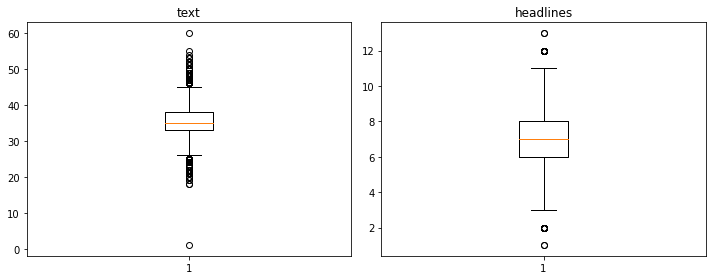

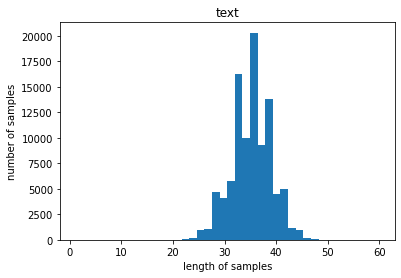

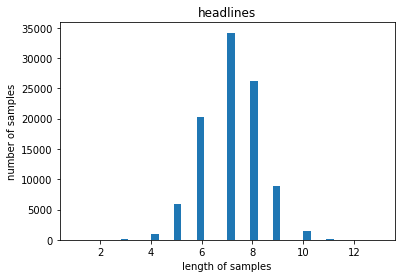

In [49]:
length_stat(data, 'text', 'headlines')

일단 데이터가 이미 잘 정리되어있는 데이터인 것 같다.

정규분포로 깔끔하게 나와있는것을 확인할 수 있다.

히스토그램에서 확인할 수 있듯이 50을 넘기면 시각적으로 확인이 안되는 수준이기 때문에

text_max = 50

headlien_max = 10으로 설정하면 적절할 듯 하다.

In [61]:
text_max_len = 50
headline_max_len = 10

In [62]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


In [63]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.999857523763001
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.9978323258228002


거의 100%의 데이터를 사용한다.

지정한 최대길이보다 긴 데이터를 잘라준다.

In [68]:
data = data[data.apply(lambda x: len(x['text'].split()) <= text_max_len 
                                  and len(x['headlines'].split()) <= headline_max_len, axis=1)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98036


### SOS와 EOS 추가하기
seq2seq 구조에서 안정성과 정확성을 위해 필요하기 때문에 시작점과 끝나는지점을 알려줄 토큰을 추가한다.

In [75]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

/tmp/ipykernel_1825/815340834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken ' + x)
/tmp/ipykernel_1825/815340834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')


,headlines,text,decoder_input,decoder_output,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers,sostoken upgrad learner switches career ml al salary hike,upgrad learner switches career ml al salary hike eostoken,upgrad learner switches career ml al salary hike eostoken
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit,sostoken delhi techie wins free food swiggy one year cred,delhi techie wins free food swiggy one year cred eostoken,delhi techie wins free food swiggy one year cred eostoken
2,new zealand end rohit sharma led india match winning streak,new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history,sostoken new zealand end rohit sharma led india match winning streak,new zealand end rohit sharma led india match winning streak eostoken,new zealand end rohit sharma led india match winning streak eostoken
3,aegon life iterm insurance plan helps customers save tax,aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental death benefit rider life cover age years,sostoken aegon life iterm insurance plan helps customers save tax,aegon life iterm insurance plan helps customers save tax eostoken,aegon life iterm insurance plan helps customers save tax eostoken
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkumar hirani sonam kapoor said known hirani many years true metoo movement get derailed metoo movement always believe woman case need reserve judgment added hirani accused assistant worked sanju,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken,known hirani yrs metoo claims true sonam eostoken


dataframe 복사본에 저장될 수 있다는 경고이지만 제대로 데이터에 반영되었다.

In [81]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 훈련데이터, 테스트데이터 분리

In [82]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[64827 90157 29541 ... 20032 47737 47974]


데이터 셔플

In [83]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [84]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19607


ratio 8:2

In [85]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78429
훈련 레이블의 개수 : 78429
테스트 데이터의 개수 : 19607
테스트 레이블의 개수 : 19607


### 정수 인코딩

In [90]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

단어들의 빈도수 확인

In [99]:
threshold = 5
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69471
등장 빈도가 4번 이하인 희귀 단어의 수: 43144
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 26327
단어 집합에서 희귀 단어의 비율: 62.10361157893222
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.666635172358657


### 69000개의 단어 중 4회 이하인 단어의 비중 62%
### 위에서 제안하는 집합크기 26000을 사용

In [101]:
src_vocab = 26000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 26000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합을 단어 빈도수를 기준으로 정렬

In [102]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[5, 446, 266, 2748, 2150, 81, 104, 39, 473, 2212, 262, 1436, 1889, 3871, 2575, 274, 3803, 1240, 54, 30, 200, 5, 4031, 1105, 400, 664, 2150, 5918, 2302, 7565, 5272, 117, 23963, 1752, 8976, 337], [533, 1515, 121, 156, 108, 488, 130, 7, 556, 2119, 863, 72, 72, 3, 402, 34, 1, 68, 130, 4, 18, 25, 102, 7, 556, 3097, 826, 863, 3, 402, 321, 639, 1, 1515], [2087, 2831, 366, 917, 66, 695, 4387, 7566, 2846, 1335, 276, 176, 14, 6801, 4451, 8279, 917, 66, 7566, 211, 2576, 1788, 76, 1173, 70, 199, 677, 242, 931, 2088, 4550, 490, 322, 149, 1476]]


headline에도 적용

In [103]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [104]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29923
등장 빈도가 4번 이하인 희귀 단어의 수: 18498
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11425
단어 집합에서 희귀 단어의 비율: 61.81866791431341
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.007842891203413


### 11000으로 지정

In [105]:
tar_vocab = 11000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 4, 666, 974, 3877, 1328, 219, 532, 858, 848], [1, 105, 4385, 1783, 135, 135], [1, 1077, 571, 167, 354, 4907, 2283, 783], [1, 35, 336, 193, 2579, 8037, 146, 1568], [1, 1699, 398, 643, 1493, 3353, 760, 1060]]
target
decoder  [[4, 666, 974, 3877, 1328, 219, 532, 858, 848, 2], [105, 4385, 1783, 135, 135, 2], [1077, 571, 167, 354, 4907, 2283, 783, 2], [35, 336, 193, 2579, 8037, 146, 1568, 2], [1699, 398, 643, 1493, 3353, 760, 1060, 2]]


없어진 데이터가 있는지 확인

In [106]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 2
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 78427
훈련 레이블의 개수 : 78427
테스트 데이터의 개수 : 19606
테스트 레이블의 개수 : 19606


### 패딩

In [108]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='post')

## 어텐션 매커니즘 사용하기 (추상적 요약)

In [109]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention

### 인코더층 LSTM + Dropout

In [119]:
embedding_dim = 256
hidden_size = 256

encoder_inputs = Input(shape=(text_max_len,))

# 인코드 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True,return_state=True, dropout=0.2)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.3)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

### 디코더층 설계 어텐션 매커니즘

In [122]:
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)


# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output3])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 256)      6656000     input_4[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, 50, 256), (N 525312      embedding_3[0][0]                
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련

In [123]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=1, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 39s 110ms/step - loss: 5.6285 - val_loss: 5.1891
Epoch 2/50
307/307 [==============================] - 34s 112ms/step - loss: 5.0273 - val_loss: 4.8372
Epoch 3/50
307/307 [==============================] - 34s 112ms/step - loss: 4.6886 - val_loss: 4.5763
Epoch 4/50
307/307 [==============================] - 34s 111ms/step - loss: 4.4164 - val_loss: 4.3868
Epoch 5/50
307/307 [==============================] - 34s 111ms/step - loss: 4.1998 - val_loss: 4.2639
Epoch 6/50
307/307 [==============================] - 34s 111ms/step - loss: 4.0171 - val_loss: 4.1483
Epoch 7/50
307/307 [==============================] - 34s 111ms/step - loss: 3.8599 - val_loss: 4.0690
Epoch 8/50
307/307 [==============================] - 34s 111ms/step - loss: 3.7206 - val_loss: 3.9978
Epoch 9/50
307/307 [==============================] - 34s 111ms/step - loss: 3.5927 - val_loss: 3.9449
Epoch 10/50
307/307 [==============================] - 34s 111ms/step - l

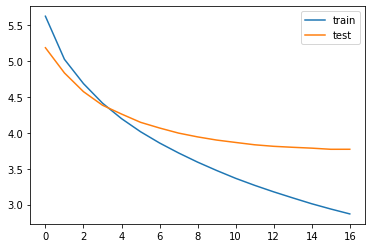

In [124]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 테스트 단계에 정수 인덱스를 다시 텍스트로 복구

In [125]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

### 테스트를 위한 별도의 모델 설계

In [127]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [128]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [132]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [133]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + tar_index_to_word[i]+' '
    
    return temp

## 추상적 요약

In [207]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("추상적예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print('\n')

원문 : pakistan cricket board welcomed ab de villiers pakistan super league tweet read goat south africa part psl warm welcome former south african international announced arrival video captioned time going party february 
실제 요약 : sostoken goat part psl pcb welcomes ab de villiers psl 
추상적예측 요약 :  pak captain imran khan gets engaged pak


원문 : sanju director rajkumar hirani responding allegations tried whitewash sanjay dutt image biopic said whitewash anyone would made mahatma gandhi hirani questioned shown girlfriends addicted drugs slept friend girlfriend 
실제 요약 : sostoken whitewash dutt would made gandhi hirani 
추상적예측 요약 :  dutt biopic sanju


원문 : japanese web giant internet group said soon allow staff receive part salary bitcoin company start paying monthly bitcoin employees japan february employees also get additional salary choose receive bitcoin incentive 
실제 요약 : sostoken japanese company start paying employees bitcoin 
추상적예측 요약 :  bitcoin price work japan


원문 : bennington wife

### 추출적 요약

In [205]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("예측 요약 :", summarize(seq2summary(decoder_input_test[i]),words=50))
    print("\n")

원문 : pakistan cricket board welcomed ab de villiers pakistan super league tweet read goat south africa part psl warm welcome former south african international announced arrival video captioned time going party february 
예측 요약 : 


원문 : sanju director rajkumar hirani responding allegations tried whitewash sanjay dutt image biopic said whitewash anyone would made mahatma gandhi hirani questioned shown girlfriends addicted drugs slept friend girlfriend 
예측 요약 : 


원문 : japanese web giant internet group said soon allow staff receive part salary bitcoin company start paying monthly bitcoin employees japan february employees also get additional salary choose receive bitcoin incentive 
예측 요약 : 


원문 : bennington wife rock band linkin park singer chester bennington committed suicide recently shared picture late husband twitter wrote would give life go back moment nervous kiss front camera chester said us baby kissed 
예측 요약 : 


원문 : jammu kashmir police friday arrested five persons connection

### 불필요한 텍스트를 모두없애 문장에서는 문장수가 충분하지않아 제대로 추출되지 않음 !

## 추출적 요약을 위해 크기를 줄이지않은 텍스트를 들고온다.

In [ ]:
from summa.summarizer import summarize
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
summa_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

# 추상적 요약과 추출 요약 비교

In [204]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("추상적예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("추출예측 요약 :",summarize(summa_data['text'][i], words=30))
    print('\n')


원문 : pakistan cricket board welcomed ab de villiers pakistan super league tweet read goat south africa part psl warm welcome former south african international announced arrival video captioned time going party february 
실제 요약 : sostoken goat part psl pcb welcomes ab de villiers psl 
추상적예측 요약 :  pak captain imran khan gets engaged pak
추출예측 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : sanju director rajkumar hirani responding allegations tried whitewash sanjay dutt image biopic said whitewash anyone would made mahatma gandhi hirani questioned shown girlfriends addicted drugs slept friend girlfriend 
실제 요약 : sostoken whitewash dutt would made gandhi hirani 
추상적예측 요약 :  dutt biopic sanju
추출예측 요약 : Boeing retained its position as the world's largest planemaker for the seventh straight year, delivering 806 aircraft in 2018.


원문 : japanese web giant internet group 

문장의 길이가 너무 짧아 추상적요약은 어느정도 문맥은 파악하였지만 다루는 내용을 원문에 핵심내용이 아님
그리고 추출적요약은 주제와 완전 다른 주제를 언급하고 있음
### 둘 다 잘 된 요약은 아닌것 같지만 그래도 추상적요약이 쫌 더 성능이 좋다.

# 회고
```
자연어처리에서는 데이터전처리과정이 많다는 것을 느꼈다. 텍스트데이터를 전처리하는 프로세스를 충분히 숙지해야 할 필요성을 느꼈다.
또한 점점 학습시간이 오래 걸리는것이 느껴진다. 이제는 모델을 설계함에있어 cost적인 부분도 고려하여야겠다는 생각이 들었다.
```